##  OCT Segmentation Results

Visualize results generated by the train_oct.py script.
Also, experiment with postprocessing.

For now, just work with results that were pre-computed on the cluster.
My laptop is struggling even just on deploy.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py
from functools import partial

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat

import GPy

sys.path.append('../..')
import cnn_tools as ct
import train_oct
import postproc_oct as ppo

Using TensorFlow backend.


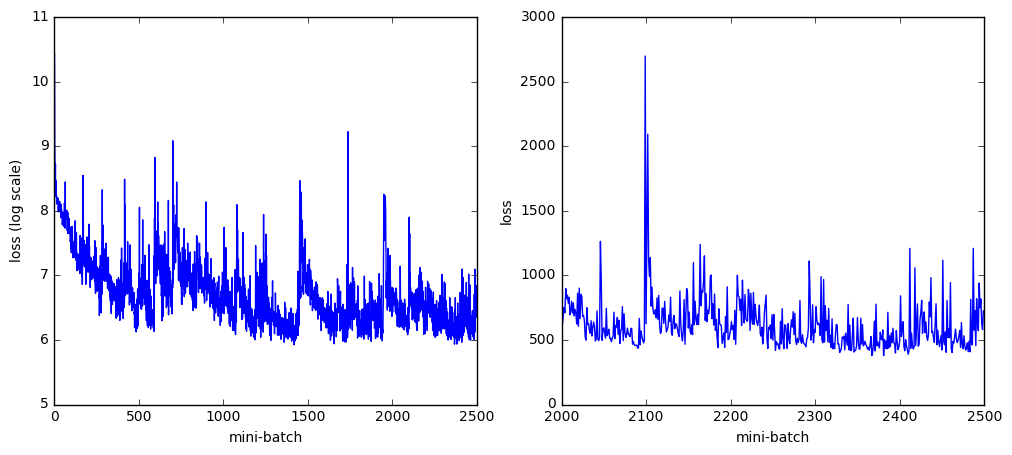

In [2]:
# Look at how training evolved
fn = 'oct_seg_fold0_valid_epoch0099.npz'

if os.path.exists(fn):
    f = np.load(fn)
    loss = f['s']
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(np.log(loss))
    plt.ylabel('loss (log scale)')
    plt.xlabel('mini-batch')
        
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(loss)-500, len(loss)), loss[-500:])
    plt.xlabel('mini-batch')
    plt.ylabel('loss')

else:
    print('weight file %s not found' % fn)
    

In [10]:
#f = np.load('oct_seg_fold0_deploy_final.npz')
f = np.load('oct_seg_fold0_deploy_final_nomirror.npz')

X = f['X']
Y = f['Y']
Y_hat = f['Y_hat']
test_slices = f['test_slices']
valid_slices = f['valid_slices']

train_slices = [x for x in range(50) if x not in test_slices and x not in valid_slices]

print('X shape:     ', X.shape)
print('Y shape:     ', Y.shape)
print('Y_hat shape: ', Y_hat.shape)
print('test slices are: ', test_slices)

X shape:      (50, 1, 512, 768)
Y shape:      (50, 1, 512, 768)
Y_hat shape:  (50, 512, 768)
test slices are:  [ 0  5 10 15 20 25 30 35 40 45]


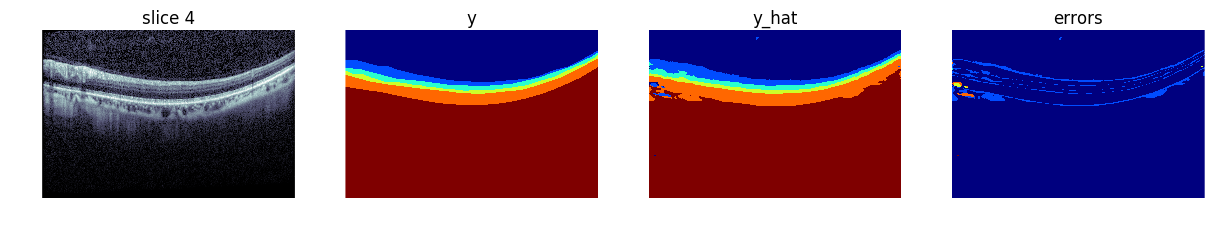

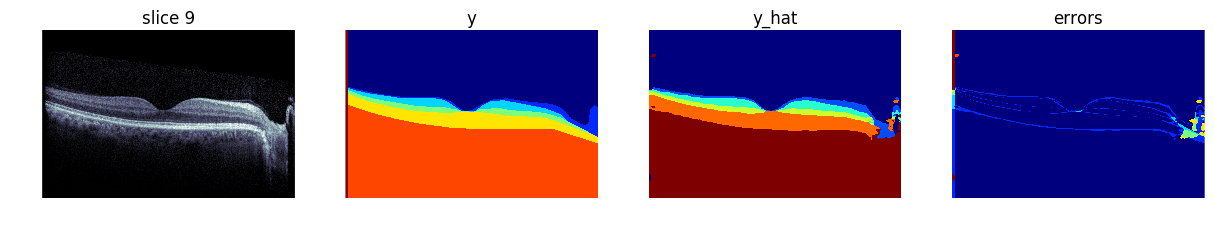

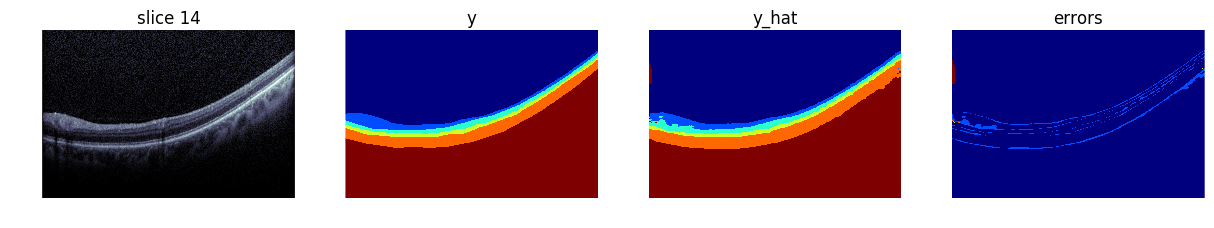

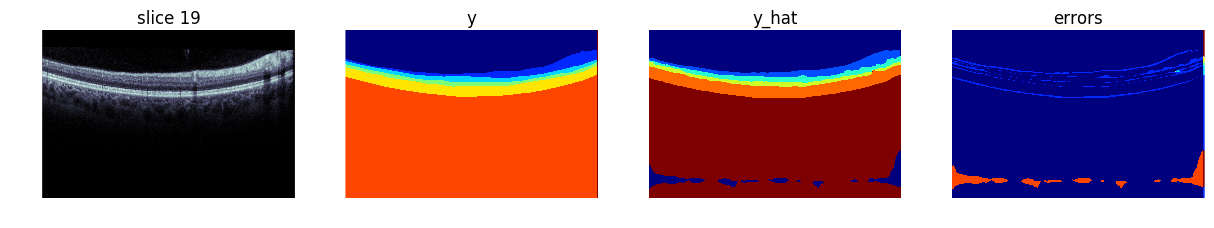

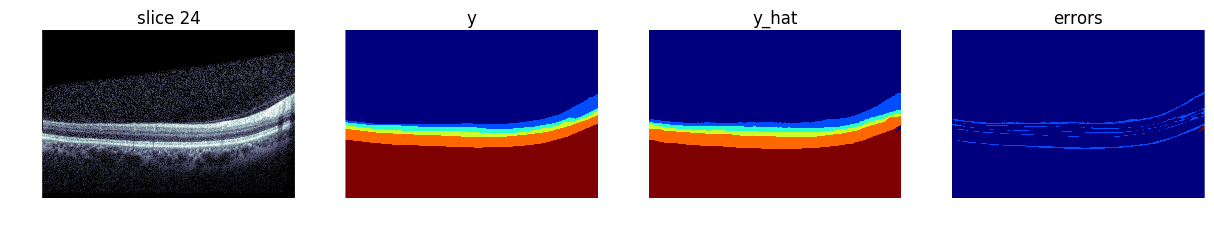

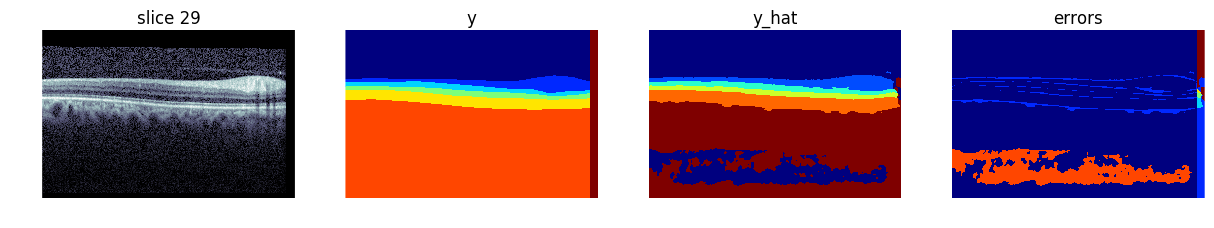

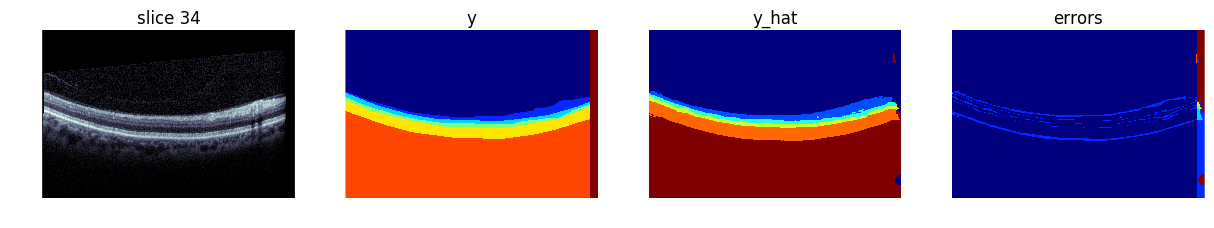

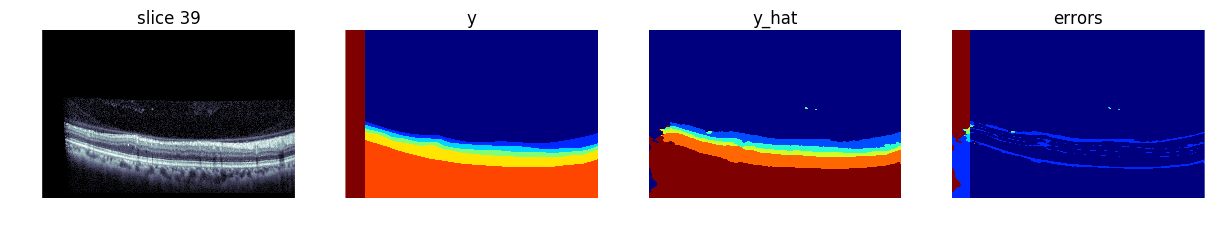

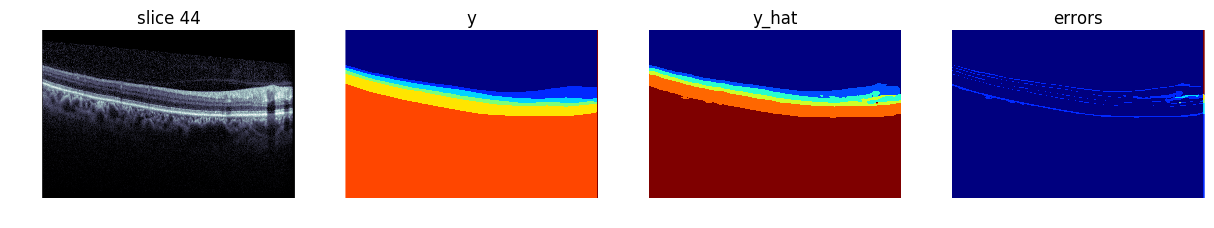

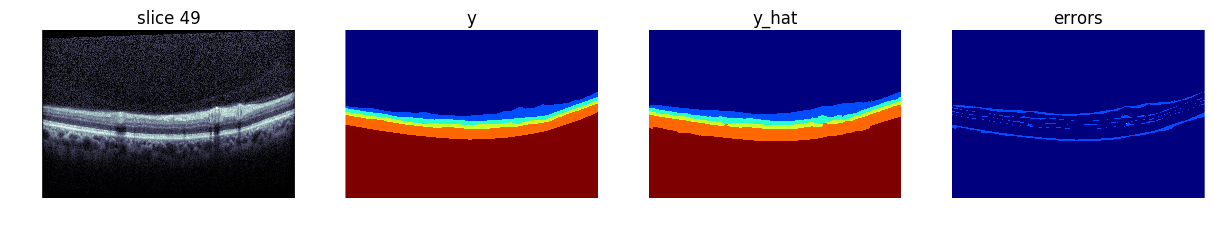

In [4]:
slices_to_view = valid_slices[:10]

for ts in slices_to_view:
    xi = np.squeeze(X[ts,...])
    yi = np.squeeze(Y[ts,...])
    yi_hat = Y_hat[ts,...]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(xi, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('slice %d' % ts)
    
    plt.subplot(1,4,2)
    #plt.imshow(xi, interpolation='none', cmap='bone')
    plt.imshow(yi, interpolation='none', cmap='jet')
    plt.axis('off')
    plt.title('y')
    
    plt.subplot(1,4,3)
    plt.imshow(yi_hat, interpolation='none')
    plt.axis('off')
    plt.title('y_hat')
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(yi - yi_hat), interpolation='none')
    plt.axis('off')
    plt.title('errors')
    
    

(50, 1, 512, 768)
(50, 1, 512, 768)


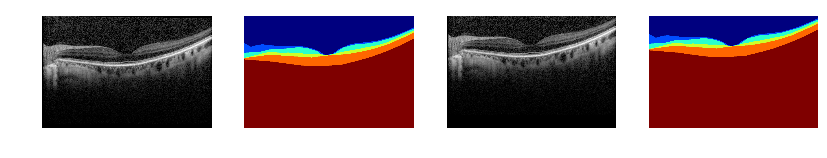

In [5]:
# here we are just visualizing the synthetic data augmentation.
print(X.shape)
print(Y.shape)

X_dy, Y_dy = train_oct.tian_shift_updown(X, Y)

idx = 0
plt.figure(figsize=(10,13))
plt.subplot(1,4,1)
plt.imshow(X[idx,0,...], interpolation=None, cmap='gray')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(Y[idx,0,...], interpolation=None, cmap='jet')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(X_dy[idx,0,...], interpolation=None, cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(Y_dy[idx,0,...], interpolation=None, cmap='jet'); plt.axis('off')

plt.show()

## Regression Experiments

Here we experiment with regression-based post-processing to obtain boundary estimates from semantic segmentation estimates.

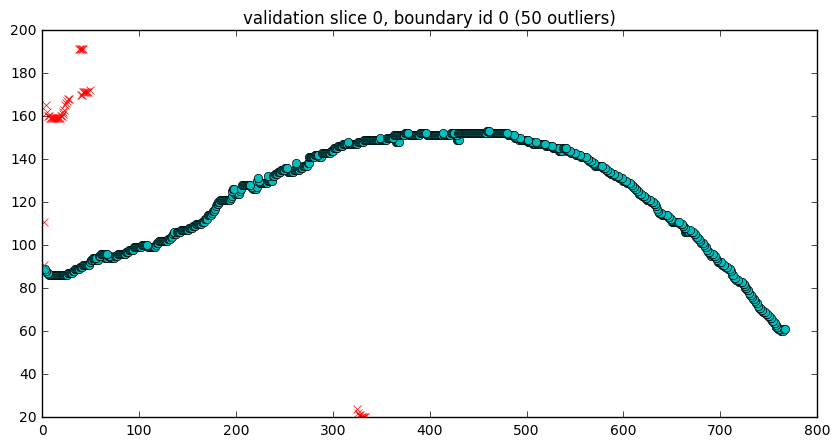

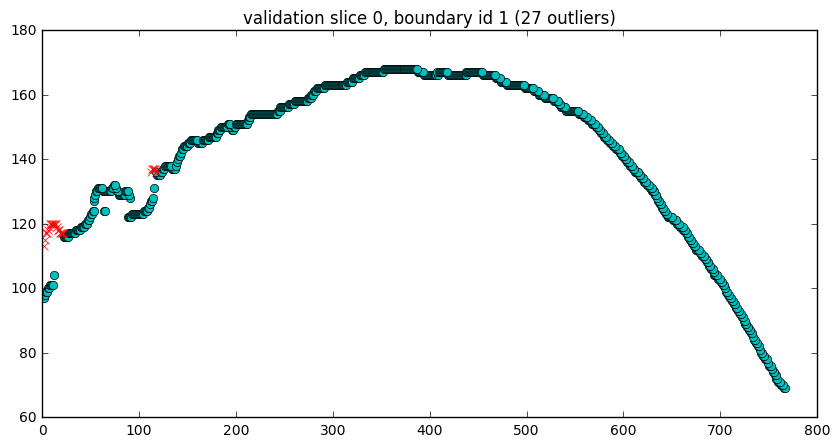

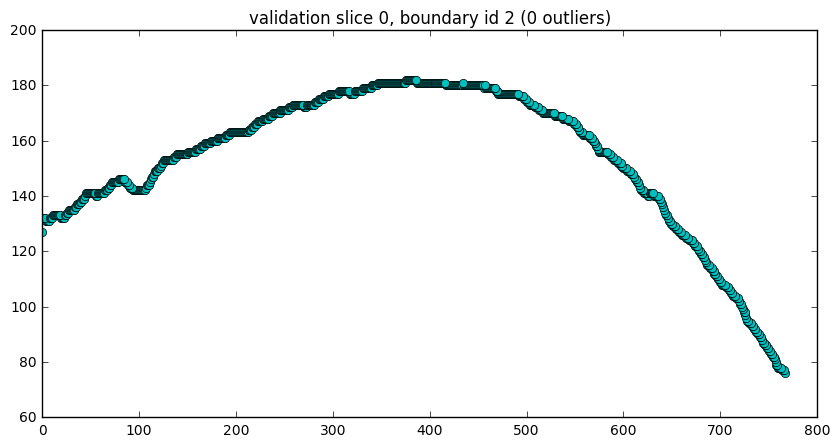

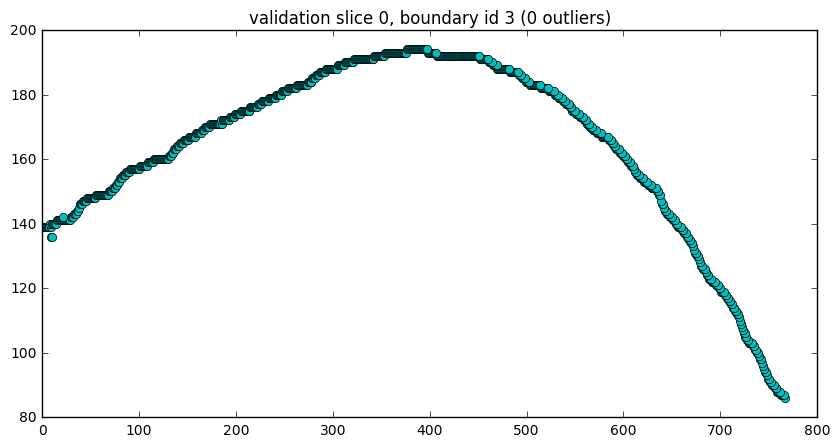

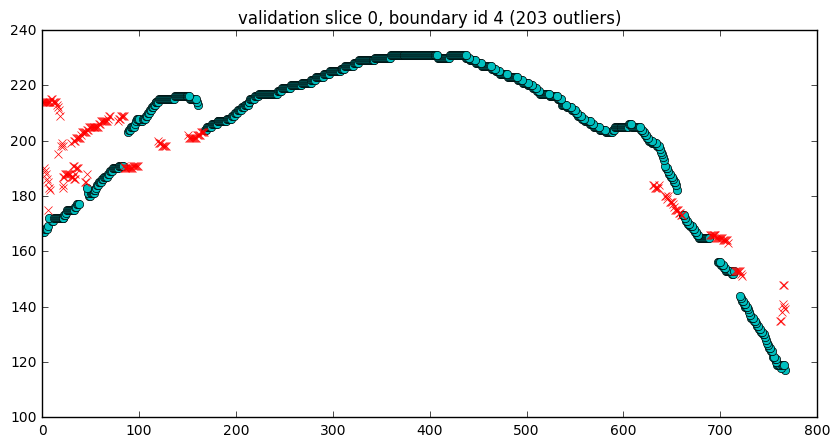

In [6]:
Y_tmp = np.squeeze(Y_hat[valid_slices[0],...])

for boundary_id in range(5):
    y_obs, x_obs = ppo.get_class_transitions(Y_tmp, boundary_id)

    is_outlier = ppo.find_outliers_via_gp(x_obs, y_obs)

    plt.figure(figsize=(10,5))
    plt.plot(x_obs[~is_outlier], y_obs[~is_outlier], 'co')
    plt.plot(x_obs[is_outlier], y_obs[is_outlier], 'rx')
    plt.title('validation slice 0, boundary id %d (%d outliers)' % (boundary_id, np.sum(is_outlier)))
    
plt.show()

20.0 50.0 2705.73873672
69.1565026345 45.7099888918 2620.60697947
171.759166658 125.660527407 2605.21085017
359.697950524 157.280884874 2595.86498282
336.595388161 41.710880006 2584.25435603
282.223610563 27.583391972 2579.98899131
244.744498684 17.0348718866 2578.70446727
for layer 1 h=244.744, sigma=17.035  (runtime=3.84 min)


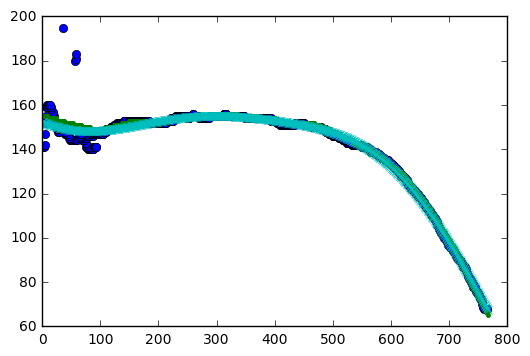

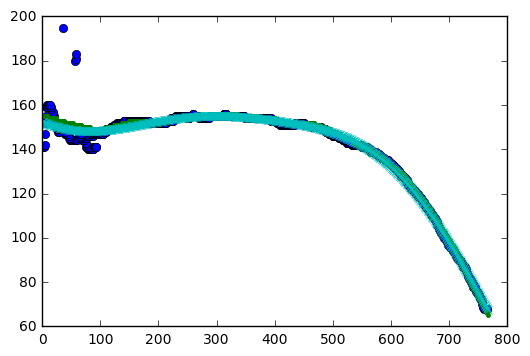

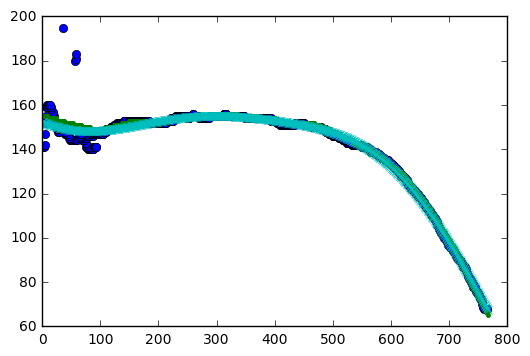

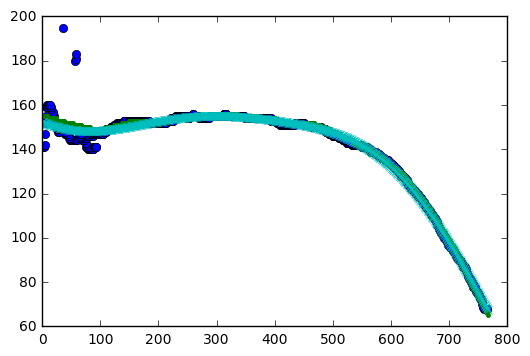

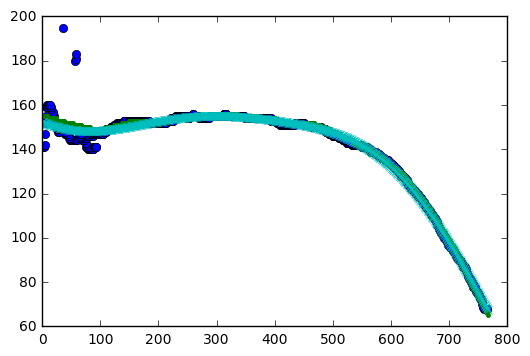

In [7]:
which_boundary = 1

def estimate_to_matrix(Y_hat, image_id):
    row, col = ppo.get_class_transitions(np.squeeze(Y_hat), which_boundary)
    image_id_vec = image_id * np.ones(row.shape)
    return np.c_[row, col, image_id_vec]
    #return np.array([row, col, image_id_vec]).T


for idx, k in enumerate(train_slices):
    est_k = estimate_to_matrix(Y_hat[k,...], idx)
    true_k = estimate_to_matrix(Y[k,...], idx)
    
    if idx == 0:
        X_train_gp = est_k
        Y_train_gp = true_k
    else:        
        X_train_gp = np.r_[X_train_gp, est_k]
        Y_train_gp = np.r_[Y_train_gp, true_k]
         

if True:         
    tic = time.time()
    h, sigma = ppo.fit_gp_hypers_1d(X_train_gp, Y_train_gp, 50)
    toc = time.time() - tic
    print('for layer %d h=%0.3f, sigma=%0.3f  (runtime=%0.2f min)' % (which_boundary, h, sigma, (toc/60.)))
else:
    h, sigma = 250, 150 # previous value


# take a look at the data
for img_idx in range(5):
    idx = 0
    r_cnn = X_train_gp[X_train_gp[:,2] == idx, 0]
    c_cnn = X_train_gp[X_train_gp[:,2] == idx, 1]
    r_true = Y_train_gp[Y_train_gp[:,2] == idx, 0]
    c_true = Y_train_gp[Y_train_gp[:,2] == idx, 1]
    
    kernel = GPy.kern.RBF(input_dim=1, variance=sigma, lengthscale=h)
    r_gp = ppo.simple_boundary_regression_1d(c_cnn, r_cnn, c_true, kernel=kernel)

    plt.figure()
    plt.plot(c_cnn, r_cnn, 'bo', c_true, r_true, 'g.', c_true, r_gp, 'cx')
    plt.show()

TODO: discard points where y_true was 6 (the "ignore these pixels" label)!
(512, 768)
(10, 512, 768)


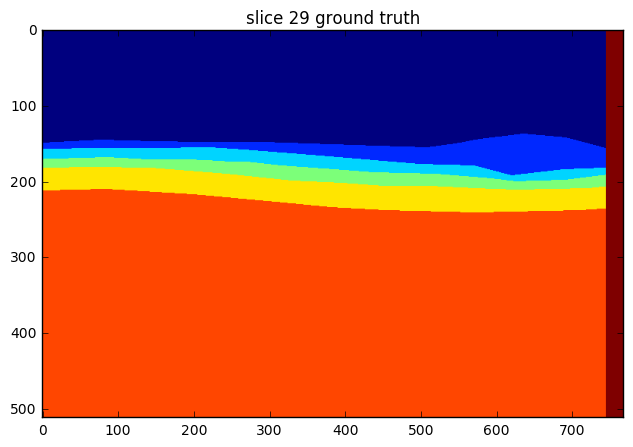

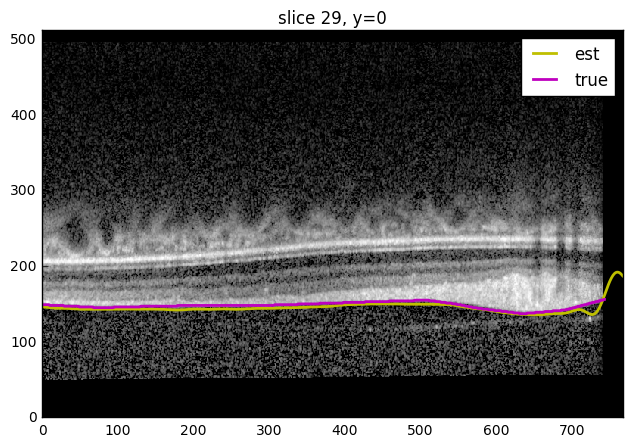

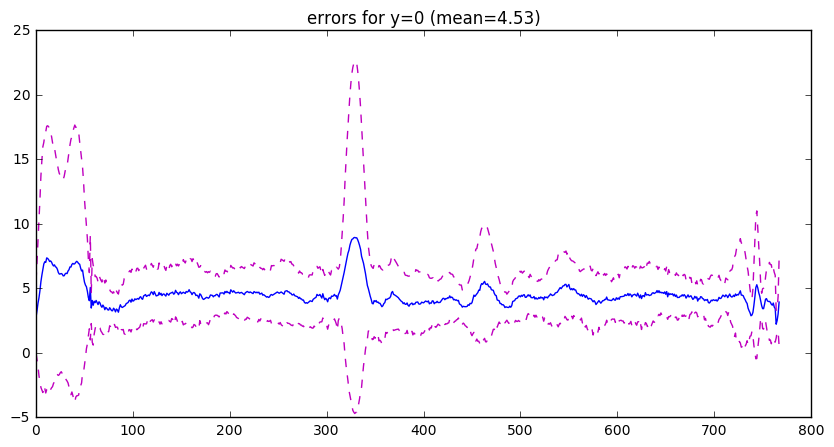

(512, 768)
(10, 512, 768)


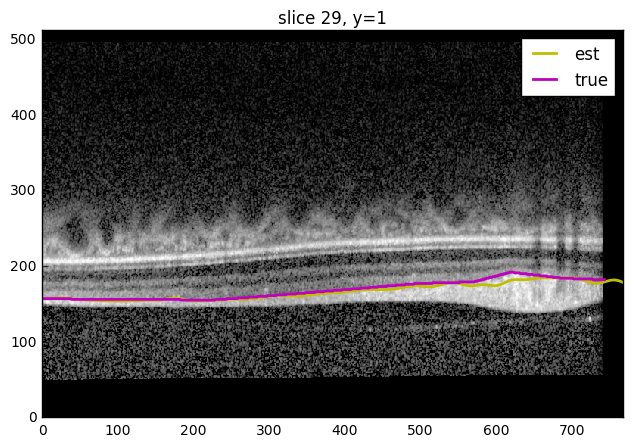

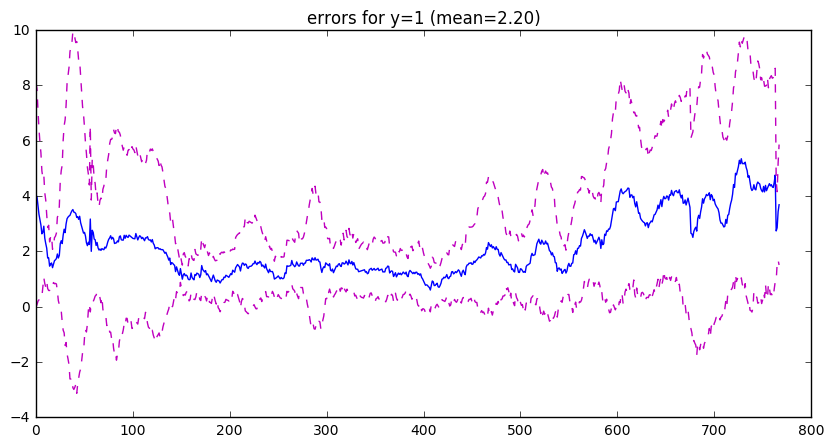

(512, 768)
(10, 512, 768)


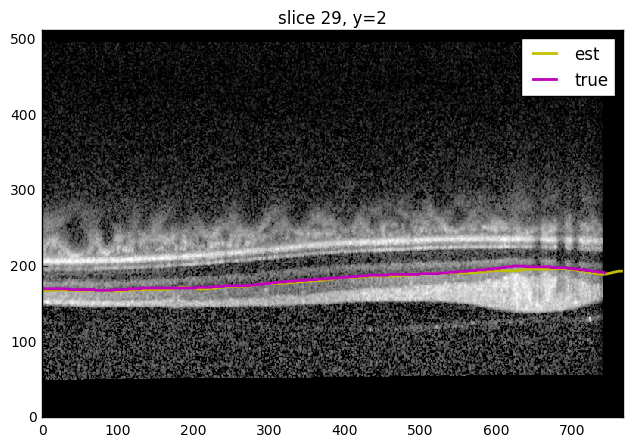

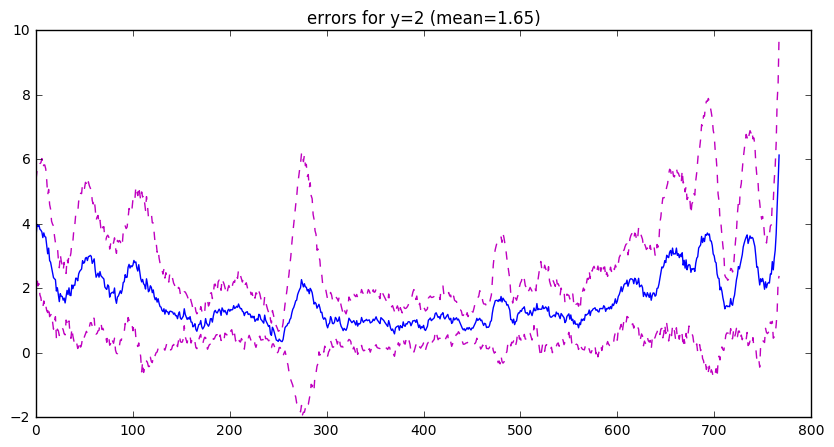

(512, 768)
(10, 512, 768)


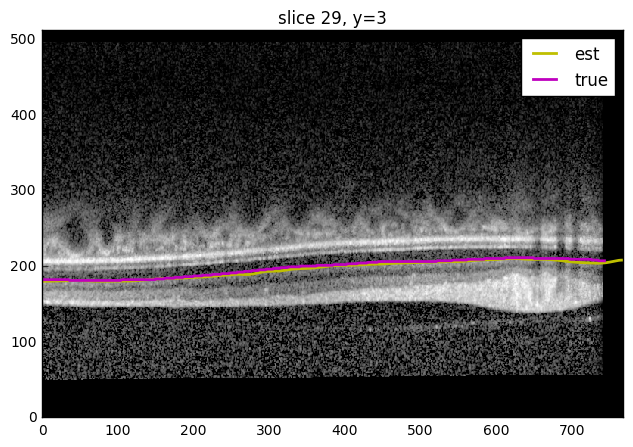

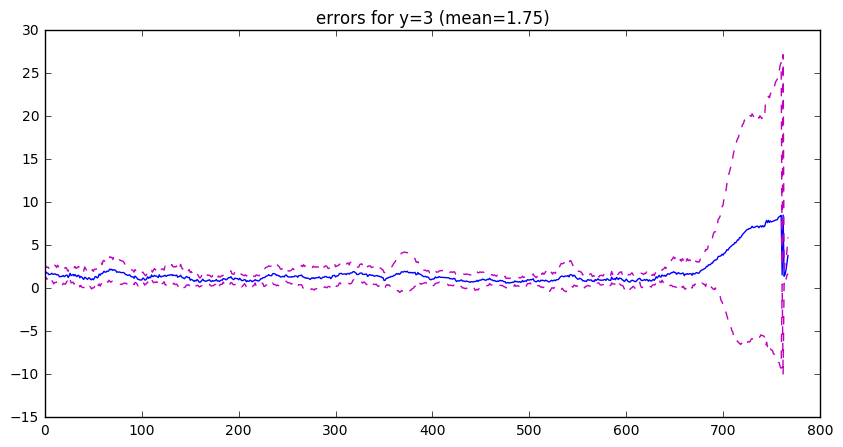

(512, 768)
(10, 512, 768)


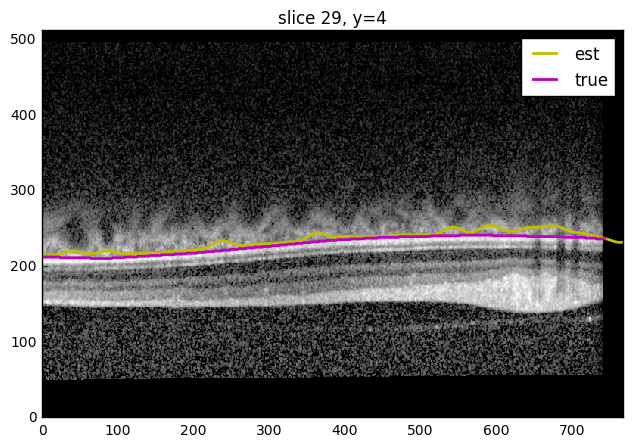

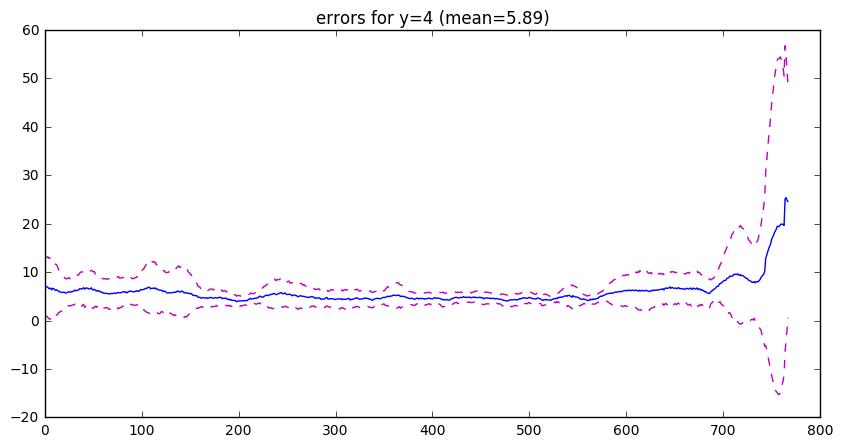

In [8]:
print('TODO: discard points where y_true was 6 (the "ignore these pixels" label)!')

Y_hat_v = np.squeeze(Y_hat[valid_slices,...])
Y_v = np.squeeze(Y[valid_slices,...])
show_idx = 5

# un-mirror
#un_mirror = lambda M: M[...,100:-100]
#Y_hat_v = un_mirror(Y_hat_v)
#Y_v = un_mirror(Y_v)


# Look at true labels for one slice
plt.figure(figsize=(10,5))
plt.imshow(Y_v[show_idx,...])
plt.title('slice %d ground truth' % valid_slices[show_idx])


for yi in [0,1,2,3,4]:
   
    # compute estimated and true boundaries
    B_hat = ppo.dense_to_boundary(Y_hat_v, yi, ppo.simple_boundary_regression_1d)
    B_true = ppo.dense_to_boundary(Y_v, yi, None)
    
    err_l1 = np.abs(B_hat - B_true)

    err_mu = np.nanmean(err_l1, axis=0)
    err_sigma = np.nanstd(err_l1, axis=0)
    
    # visualize result
    img = np.squeeze(X[valid_slices[show_idx],...])
    #img = un_mirror(img)
    xv = np.arange(img.shape[1])
    print(img.shape)
    print(Y_hat_v.shape)
    
    plt.figure(figsize=(10,5))
    plt.imshow(img, interpolation='none', cmap='gray')
    plt.plot(xv, B_hat[show_idx,:], 'y-', linewidth=2, label='est')
    plt.plot(xv, B_true[show_idx,:], 'm-', linewidth=2, label='true')
    plt.xlim([0, img.shape[-1]])
    plt.ylim([0, img.shape[-2]])
    plt.title('slice %d, y=%d' % (valid_slices[show_idx], yi))
    plt.legend()
    
    # Show aggregate results (on validation data)
    plt.figure(figsize=(10,5))
    plt.plot(xv, err_mu, 'b-', 
             xv, err_mu+err_sigma, 'm--',
             xv, err_mu-err_sigma, 'm--')
    #plt.errorbar(np.arange(B_hat.shape[1]), err_mu, err_sigma)
    plt.title('errors for y=%d (mean=%0.2f)' % (yi, np.mean(err_mu)))
    
    plt.show()

In [9]:
X0 = np.squeeze(X[0,...]);  X0 = np.flipud(X0)
x = np.arange(Y0.shape[1])

plt.figure(figsize=(15,6))
plt.imshow(X0, interpolation='none', cmap='gray')
for idx, m in enumerate(layers):
    y_mu, y_sigma = np.squeeze(m.predict(x[:,np.newaxis]))
    plt.plot(x, means[idx] + y_mu, label=idx, linewidth=2)

plt.legend(loc='upper left')
plt.title('Gaussian process layer boundary estimates (preliminary)')
plt.gca().invert_yaxis()
plt.show()


NameError: name 'Y0' is not defined

## Experiment with morphology operations

In [ ]:
from skimage.morphology import opening

for yi in [1,2,3,4]:
    foo = Y_hat == yi
    bar = opening(foo)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(Y_hat[0,...], interpolation='none')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(foo[0,...], interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('raw estimate')

    plt.subplot(1,3,3)
    plt.imshow(bar[0,...], interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('eroded and dialated estimate')

    plt.show()